# Estimate the parameters for dynamic Nelson Siegel model

## Import data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
dfs=pd.read_csv("data\\CMT_Rates.csv",index_col=0)["12/1/3":"15/12/31"]

In [2]:
dfs.columns

Index(['1 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR',
       '20 YR', '30 YR'],
      dtype='object')

## Estimate the betas

In [3]:
def betas(lamb):
    #set the parameters
    Betas=[]
    Resids=[]
    resid=0
    t=np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30])*12
    fac1=(1-np.e**(-lamb*t))/(lamb*t)
    fac2=fac1-np.e**(-lamb*t)
    #
    for i in range(len(dfs)):
        Y = dfs.iloc[i,:]
        X=np.concatenate(([fac1],[fac2]),axis=0).T
        X = sm.add_constant(X)
        model=sm.OLS(Y,X)
        result=model.fit()

        Resids.append(result.resid.tolist())
        Betas.append(result.params.tolist())
    return Betas,Resids

In [4]:
lamb=0.05
Betas,Resid=betas(lamb)
Betas[0:5]

[[3.3030696890948334, -3.139657953742664, -4.761533708303068],
 [3.361672631560115, -3.19218856618238, -4.89571321599759],
 [3.3939359436779455, -3.2183490003616058, -4.964565008914599],
 [3.3457449872588585, -3.169256041749876, -4.9232136098315795],
 [3.3458046766504426, -3.1750302535963755, -4.939635033900995]]

## Estimate the lambda

Calculate the rmse

In [5]:
def rmses(lamb):
    _,resid=betas(lamb)
    Resids=np.array(resid)
    rmses=np.sqrt(np.sum((Resids**2)/Resids.shape[1],axis=1))
    #print(Resids.shape[1])
    return rmses

In [6]:
# Use bisection to find optimal lambda
ebs=0.0001
left=0.001
right=10
lamb=(left+right)/2

while abs(left-lamb)>0.001:

    resid_sum=sum(rmses(lamb))
    if resid_sum>sum(rmses(lamb+ebs)):
        left=lamb
    else:
        right=lamb
        
    lamb=(left+right)/2
    print('rmse reduces to {}'.format(resid_sum))
        
print("The optimal estimated lambda is: "+str(lamb))
Optimal_lambda=lamb

rmse reduces to 802.6461113783082
rmse reduces to 800.0638047697244
rmse reduces to 772.8793215782033
rmse reduces to 694.7587435579632
rmse reduces to 562.7003749090593
rmse reduces to 375.2950627142752
rmse reduces to 170.78763753488238
rmse reduces to 72.44656375419154
rmse reduces to 97.84683457561887
rmse reduces to 76.98103619720398
rmse reduces to 72.43453816274115
rmse reduces to 72.02932133408056
rmse reduces to 72.10946588735865
The optimal estimated lambda is: 0.03700714111328125


# Prediction on Nelson-Siegel Model

## Top 20 RMSE

In [7]:
Opt_lambda=Optimal_lambda
Rrmses=pd.DataFrame(rmses(Opt_lambda))
Betas,_=betas(Opt_lambda)
Betas=pd.DataFrame(Betas)

In [8]:
results=pd.concat([Betas,Rrmses],axis=1)
results.columns=["beta1","beta2","beta3","rmse"]

In [9]:
Top_rmse=results.sort_values(["rmse"],ascending=False).head(20)
Top_rmse.head()

,beta1,beta2,beta3,rmse
499,4.773557,-4.832017,-3.992850,0.132366
495,4.688799,-4.751083,-3.850718,0.127781
497,4.741371,-4.804284,-3.927889,0.127384
500,4.722909,-4.778427,-3.977851,0.126508
498,4.696110,-4.749588,-3.938016,0.125187


## Predict the out-sample data

Have the betas data, fit them with AR(1) model and store the result, calculate the Half-Life.

In [10]:
beta_data=[]
# Size of beta_data is 20*180*11
for i in range(20):
    beta_data.append(results.iloc[Top_rmse.index[i]-180:Top_rmse.index[i],0:3].values)

In [11]:
from scipy.ndimage.interpolation import shift
import statsmodels.api as sm
def shiftLR(Y,n):
    X=shift(Y, n, cval=np.NaN)
    Y=Y[n:]
    X=X[n:]
    X= sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    return model.params

In [12]:
from statsmodels.tsa.arima_model import ARMA
from scipy.ndimage.interpolation import shift
import statsmodels.api as sm

HL=[]
Predictions=[]
for i in range(20):
    halflife=[]
    pred=[]
    for j in range(3):
        p1=shiftLR(beta_data[i][:,j],5)
        p2=shiftLR(beta_data[i][:,j],10)
        p3=shiftLR(beta_data[i][:,j],30)
       
        # calculate the half life
        cur_hf1=round(-np.log(2)/np.log(p1[1]),4)
        cur_hf2=round(-np.log(2)/np.log(p2[1]),4)
        cur_hf3=round(-np.log(2)/np.log(p3[1]),4)
        # predict the next 5, 10, 30 days out sample
        prediction5 =round( beta_data[i][:,j][-1]*p1[1]+p1[0],4)
        prediction10 =round( beta_data[i][:,j][-1]*p2[1]+p2[0],4)
        prediction30 =round(beta_data[i][:,j][-1]*p3[1]+p3[0],4)
        pred.append([prediction5,prediction10,prediction30])
        halflife.append([cur_hf1,cur_hf2,cur_hf3])
    Predictions.append(pred)
    HL.append(halflife)

C:\Users\wenca\APP\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


In [13]:
Half_life=pd.DataFrame(HL)
Half_life.index=dfs.index[Top_rmse.index]
Half_life.columns=["Beta1","Beta2","Beta3"]
Half_life.head()

,Beta1,Beta2,Beta3
Date,,,
13/12/31,"[7.5408, 3.7907, 1.0158]","[7.7484, 3.8351, 0.9093]","[2.6007, 0.9579, nan]"
13/12/24,"[9.615, 4.6256, 1.1036]","[9.4848, 4.5485, 0.984]","[2.6237, 1.0095, nan]"
13/12/27,"[8.686, 4.216, 1.0537]","[8.7931, 4.2206, 0.9421]","[2.5021, 0.9667, nan]"
14/1/2,"[7.269, 3.6158, 0.9967]","[7.504, 3.6707, 0.8916]","[2.6103, 0.9511, nan]"
13/12/30,"[8.0834, 3.9934, 1.0366]","[8.2406, 4.0181, 0.9276]","[2.5447, 0.9601, nan]"


Some of the halflives are nan which means they are not stationary. The autocorrelation parameters are negative for those.

In [14]:
beta_pred=round(pd.DataFrame(Predictions),3)
beta_pred.index=dfs.index[Top_rmse.index]
beta_pred.columns=["Beta1","Beta2","Beta3"]
beta_pred.head()

,Beta1,Beta2,Beta3
Date,,,
13/12/31,"[4.6937, 4.6951, 4.6719]","[-4.7468, -4.746, -4.6836]","[-4.0099, -4.1126, -4.3192]"
13/12/24,"[4.6308, 4.64, 4.6392]","[-4.6824, -4.6891, -4.6512]","[-3.9646, -4.0834, -4.3236]"
13/12/27,"[4.7009, 4.7036, 4.6766]","[-4.7669, -4.766, -4.6936]","[-3.9258, -4.0598, -4.3326]"
14/1/2,"[4.7645, 4.7578, 4.7102]","[-4.8225, -4.8131, -4.7213]","[-4.0526, -4.1377, -4.3093]"
13/12/30,"[4.7356, 4.7348, 4.6962]","[-4.7976, -4.7936, -4.7101]","[-4.0031, -4.1096, -4.3191]"


In [15]:
def NSpred(B1,B2,B3,lamb):
    #set the parameters

    t=np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30])*12
    fac1=(1-np.e**(-lamb*t))/(lamb*t)
    fac2=fac1-np.e**(-lamb*t)
    Y=B1+B2*fac1+B3*fac2
    #return the <1*11> vector
    return Y

In [16]:
pred5d=[]
pred10d=[]
pred30d=[]
# 20 days insample data
for i in range(20):

    # 5 day out sample prediction
    B1=beta_pred.iloc[i,0][0]
    B2=beta_pred.iloc[i,1][1]
    B3=beta_pred.iloc[i,2][2]
    pred5d.append(NSpred(B1,B2,B3,Opt_lambda))
    
    # 10 day out sample prediction
    B1=beta_pred.iloc[i,0][0]
    B2=beta_pred.iloc[i,1][1]
    B3=beta_pred.iloc[i,2][2]
    pred10d.append(NSpred(B1,B2,B3,Opt_lambda))
    
    # 30 day out sample prediction
    B1=beta_pred.iloc[i,0][0]
    B2=beta_pred.iloc[i,1][1]
    B3=beta_pred.iloc[i,2][2]
    pred30d.append(NSpred(B1,B2,B3,Opt_lambda))


Shape of the pred5d is 20 * 11, which means there are 20 <1*11> prediction which predict 5 days after the current data. Choose 5 days to see the prediction result.

In [17]:
print(np.shape(pred5d))
round(pd.DataFrame(pred5d,columns=dfs.columns,index=Top_rmse.index+5).head(),3)

(20, 11)


,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
504,-0.044,-0.021,0.024,0.144,0.463,0.825,1.523,2.101,2.727,3.674,4.013
500,-0.051,-0.030,0.011,0.126,0.437,0.792,1.482,2.054,2.676,3.617,3.954
502,-0.056,-0.033,0.012,0.133,0.454,0.817,1.518,2.098,2.727,3.677,4.018
505,-0.038,-0.013,0.035,0.162,0.492,0.861,1.570,2.153,2.785,3.738,4.080
503,-0.048,-0.024,0.023,0.148,0.474,0.840,1.546,2.128,2.759,3.710,4.052


Choose the same Top 5 RMSE days to see the true value.

In [18]:
dfs.iloc[Top_rmse.index[0:5]+5,:]

,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,
14/1/8,0.00,0.05,0.08,0.13,0.43,0.87,1.77,2.44,3.01,3.67,3.90
14/1/2,0.01,0.07,0.09,0.13,0.39,0.76,1.72,2.41,3.00,3.68,3.92
14/1/6,0.01,0.05,0.08,0.12,0.40,0.78,1.70,2.38,2.98,3.66,3.90
14/1/9,0.01,0.04,0.06,0.13,0.44,0.86,1.75,2.41,2.97,3.62,3.88
14/1/7,0.01,0.04,0.08,0.13,0.40,0.80,1.69,2.37,2.96,3.64,3.88


The 5-day prediction of the dates we choose are very close to the true value .

## Compare the result with Random Walk prediction

According to random walk assumption:
$$\hat{y}_{t+h/t}(\tau)=y_t(\tau)$$
The forecast is always "no change"

Use the data of the top 1 RMSE date to represent the prediction by Nelson-Siegel model.

In [19]:
NS_pred=pd.DataFrame(pred5d,columns=dfs.columns,index=Top_rmse.index+5).iloc[0,:]
RW_data=dfs.iloc[Top_rmse.index[0],:]
T_data=dfs.iloc[Top_rmse.index[0]+5,:]

Compare the 5th day prediction data and data under random walk assumption.

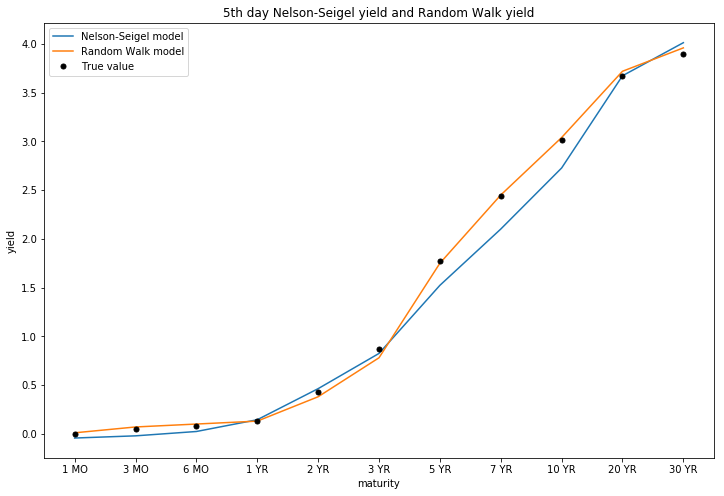

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(NS_pred,label='Nelson-Seigel model')
plt.plot(RW_data,label='Random Walk model')
plt.plot(T_data,"ro",color="black",label='True value',markersize=5)
plt.legend(loc='upper left')
plt.xlabel('maturity')
plt.title('5th day Nelson-Seigel yield and Random Walk yield')
plt.ylabel('yield')
plt.show()

Use the top 1 RMSE data to represent the prediction by Nelson-Siegel model, and compare the 10th day prediction data and data under random walk assumption.

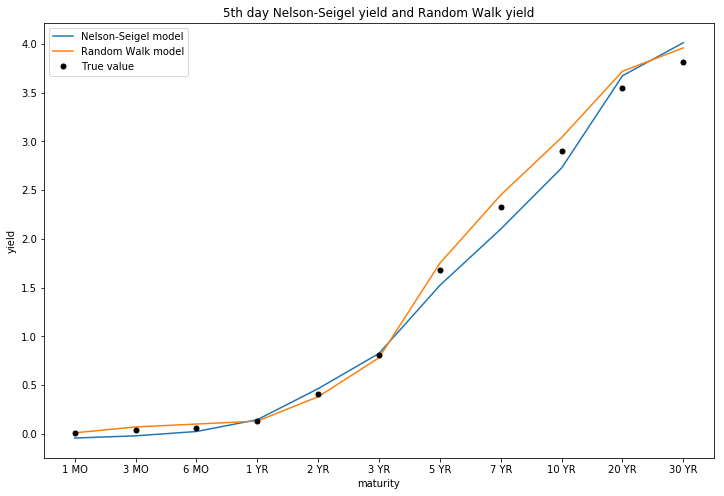

In [21]:
NS_pred=pd.DataFrame(pred10d,columns=dfs.columns,index=Top_rmse.index+10).iloc[0,:]
RW_data=dfs.iloc[Top_rmse.index[0],:]
T_data=dfs.iloc[Top_rmse.index[0]+10,:]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(NS_pred,label='Nelson-Seigel model')
plt.plot(RW_data,label='Random Walk model')
plt.plot(T_data,"ro",color="black",label='True value',markersize=5)
plt.legend(loc='upper left')
plt.xlabel('maturity')
plt.title('10th day Nelson-Seigel yield and Random Walk yield')
plt.ylabel('yield')
plt.show()

Use the top 1 RMSE data to represent the prediction by Nelson-Siegel model, and compare the 30th day prediction data and data under random walk assumption.

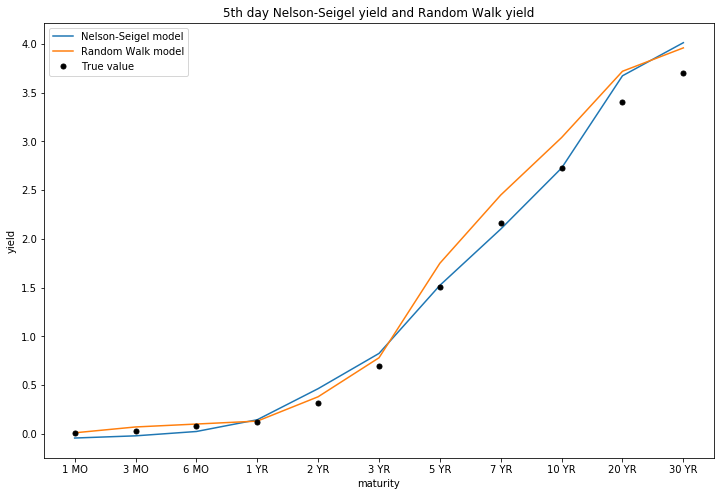

In [22]:
NS_pred=pd.DataFrame(pred30d,columns=dfs.columns,index=Top_rmse.index+30).iloc[0,:]
RW_data=dfs.iloc[Top_rmse.index[0],:]
T_data=dfs.iloc[Top_rmse.index[0]+30,:]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(NS_pred,label='Nelson-Seigel model')
plt.plot(RW_data,label='Random Walk model')
plt.plot(T_data,"ro",color="black",label='True value',markersize=5)
plt.legend(loc='upper left')
plt.xlabel('maturity')
plt.title('30th day Nelson-Seigel yield and Random Walk yield')
plt.ylabel('yield')
plt.show()

It is easy to see that when prediction window is small, the Nelson-Seigel model and Random Walk model have the similar prediction ability. 

However, with more days away from the spot day, the Nelson-Seigel would have better prediction ability than Random Walk model, because with more days go by, the assumption of Random Walk model that the forecast is always "no change" would not hold anymore.